In [1]:
import pandas as pd
import numpy as np
import colorsys
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors

from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.patches import Rectangle
from matplotlib.scale import ScaleBase, register_scale
from matplotlib.transforms import Transform
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import LogLocator

pd.options.mode.chained_assignment = None  # default='warn'

# Color schema

In [2]:
from color_schema import *

In [3]:
def lighten_color(color, amount=0.5):
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mcolors.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
class CustomTransform(Transform):
    input_dims = 1
    output_dims = 1
    is_separable = True
    has_inverse = True

    def __init__(self, threshold, lower_range, upper_range):
        Transform.__init__(self)
        self.threshold = threshold
        self.lower_range = lower_range
        self.upper_range = upper_range

    def transform_non_affine(self, a):
        a = np.maximum(a, 10**self.lower_range)  # Clip values to the minimum of the lower range
        mask = a < self.threshold
        out = np.empty(a.shape, dtype=np.float64)
        out[mask] = 0.7 * (np.log10(a[mask]) - self.lower_range) / (np.log10(self.threshold) - self.lower_range)
        out[~mask] = 0.7 + 0.3 * (np.log10(a[~mask]) - np.log10(self.threshold)) / (self.upper_range - np.log10(self.threshold))
        return out

    def inverted(self):
        return CustomTransform.InvertedCustomTransform(self.threshold, self.lower_range, self.upper_range)

    class InvertedCustomTransform(Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
        has_inverse = True

        def __init__(self, threshold, lower_range, upper_range):
            Transform.__init__(self)
            self.threshold = threshold
            self.lower_range = lower_range
            self.upper_range = upper_range

        def transform_non_affine(self, a):
            mask = a < 0.7
            out = np.empty(a.shape, dtype=np.float64)
            out[mask] = 10 ** (self.lower_range + a[mask] / 0.7 * (np.log10(self.threshold) - self.lower_range))
            out[~mask] = 10 ** (np.log10(self.threshold) + (a[~mask] - 0.7) / 0.3 * (self.upper_range - np.log10(self.threshold)))
            return out

        def inverted(self):
            return CustomTransform(self.threshold, self.lower_range, self.upper_range)

class CustomScale(ScaleBase):
    name = 'custom'

    def __init__(self, axis, threshold=1e6, lower_range=-6, upper_range=34, **kwargs):
        ScaleBase.__init__(self, axis)
        self.threshold = threshold
        self.lower_range = lower_range
        self.upper_range = upper_range

    def get_transform(self):
        return CustomTransform(self.threshold, self.lower_range, self.upper_range)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(plt.FixedLocator([10**i for i in range(self.lower_range, self.upper_range+1, 3)]))
        axis.set_major_formatter(FuncFormatter(lambda x, p: f'$10^{{{int(np.log10(x))}}}$'))
        axis.set_minor_locator(plt.NullLocator())
        axis.set_minor_formatter(plt.NullFormatter())

register_scale(CustomScale)

def draw_combined_trend_plot(dataframes, titles, methods_list, output_filename, box_positions=[0, 0.1, 0.2, 0.3], label_total_width=0.5, label_start_x=0.09, draw_middle_line=False):
    fig, ax = plt.subplots(figsize=(15, 10))  # Increased figure size

    num_dfs = len(dataframes)
    
    all_methods = set(method for methods in methods_list for method in methods)

    # Calculate the width for each benchmark based on its number of methods
    benchmark_widths = [len(methods) for methods in methods_list]
    total_methods = sum(benchmark_widths)
    total_width = 0.9 * num_dfs  # Increased total width to reduce margins
    width_per_method = total_width / total_methods

    # Calculate fixed_width and padding
    fixed_width = width_per_method * 0.8  # 80% of width_per_method for each box
    benchmark_padding = width_per_method * 0.3  # 20% of width_per_method for padding

    # Calculate positions for each benchmark
    positions = []
    benchmark_starts = [0]
    current_pos = 0
    gap = 0  # Adjust this value to increase or decrease the gap between benchmarks
    for width in benchmark_widths:
        benchmark_width = width * width_per_method
        positions.append(current_pos + benchmark_width / 2)
        current_pos += benchmark_width + gap  # Add the gap after each benchmark
        benchmark_starts.append(current_pos)

    # Draw category backgrounds and position boxes
    for i, (df, methods) in enumerate(zip(dataframes, methods_list)):
        benchmark_start = benchmark_starts[i]
        benchmark_width = benchmark_starts[i+1] - benchmark_start
        usable_width = benchmark_width - 2 * benchmark_padding
        
        present_categories = [cat for cat, cat_methods in categories.items() if any(m in methods for m in cat_methods)]
        
        # Calculate the total number of methods across all categories
        total_methods_in_benchmark = sum(len([m for m in categories[cat] if m in methods]) for cat in present_categories)
        
        # Calculate the width for each box
        box_width = usable_width / total_methods_in_benchmark
        
        category_start = benchmark_start + benchmark_padding
        for category in present_categories:
            category_methods = [m for m in categories[category] if m in methods]
            category_width = len(category_methods) * box_width
            
            # Draw category background
            rect = patches.Rectangle((category_start, 0), category_width, 1, 
                                     fill=True, facecolor=category_colors[category], 
                                     alpha=0.3, transform=ax.get_xaxis_transform(), 
                                     zorder=0)
            ax.add_patch(rect)
            
            # Position boxes within the category
            for k, method in enumerate(category_methods):
                if method in all_methods:
                    df_filtered = df[df["cardinality"] != 0]
                    df_filtered.loc[:, f"{method}_error"] = df_filtered[method] / df_filtered["cardinality"]
                    method_data = df_filtered[f"{method}_error"]
                    
                    box_pos = category_start + (k + 0.5) * box_width
                    bp = ax.boxplot([method_data], 
                                    positions=[box_pos], 
                                    widths=box_width * 0.8,
                                    patch_artist=True)
                    
                    color = ESTIMATOR_COLORS[method_names[method]]
                    pattern = category_patterns[category]
                
                    for patch in bp['boxes']:
                        patch.set_facecolor(color)
                        patch.set_edgecolor('black')
                        patch.set_hatch(pattern)
            
            category_start += category_width

    # Set x-axis ticks and labels
    ax.set_xticks(positions)
    
    x_labels = [f"{title}\n({len(df)} queries)" for df, title in zip(dataframes, titles)]
    ax.set_xticklabels(x_labels)

    for label in ax.get_xticklabels():
        label.set_fontsize(18)

    plt.ylabel("Estimation Error", fontsize=26)
    
    # Create separate legends for each category
    filtered_categories = []
    for category, category_methods in categories.items():
        present_methods = [method for method in category_methods if method in all_methods]
        if present_methods:
            filtered_categories.append((category, present_methods))

    if filtered_categories:
        legends = []
        
        total_width = label_total_width
        box_width = total_width / len(filtered_categories)
        start_x = label_start_x

        for i, (category, category_methods) in enumerate(filtered_categories):
            legend_elements = []
            legend_labels = []
            
            pattern = category_patterns[category]
            
            for method in category_methods:
                if method in all_methods:
                    color = ESTIMATOR_COLORS[method_names[method]]
                    legend_elements.append(patches.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=pattern))
                    legend_labels.append(method_names[method])
            
            # Create a legend for this category
            legend = ax.legend(legend_elements, legend_labels,
                            title=category,
                            loc='upper center',
                            # bbox_to_anchor=(start_x + i * box_width, 1),
                            bbox_to_anchor=(box_positions[i], 1),
                            bbox_transform=ax.transAxes,
                            fontsize=17,
                            title_fontsize=17,
                            frameon=True,
                            edgecolor='black',
                            borderaxespad=0,
                            handletextpad=0.5,
                            columnspacing=1.0)
            
            # Set the legend title to bold
            legend.get_title().set_fontweight('bold')
            
            # Set the background color of the legend
            frame = legend.get_frame()
            lightened_color = lighten_color(category_colors[category], amount=0.3)
            frame.set_facecolor(lightened_color)
            frame.set_alpha(1.0)
            
            # Add the legend to the list of legends
            legends.append(legend)
        
        # Add all legends to the plot
        for legend in legends:
            ax.add_artist(legend)

    ax.axhline(y=1, color='red', linestyle='--', linewidth=1.5, alpha=0.7, zorder=5)


    plt.xticks(fontsize=24)
    plt.yticks(fontsize=18)

    plt.yscale('custom', threshold=1e6, lower_range=-6, upper_range=34)

    major_ticks = [1e-6, 1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6, 1e10, 1e14, 1e18, 1e22, 1e26, 1e30, 1e34]
    ax.set_yticks(major_ticks)
    
    minor_ticks = []
    for i in range(len(major_ticks) - 1):
        log_start = np.log10(major_ticks[i])
        log_end = np.log10(major_ticks[i+1])
        minor_ticks.extend(np.logspace(log_start, log_end, num=9, endpoint=False)[1:])
    ax.set_yticks(minor_ticks, minor=True)

    ax.yaxis.grid(True, which='major', linestyle='-', linewidth=1.0, alpha=0.6)

    # Add vertical lines between benchmarks
    for end in benchmark_starts[1:-1]:
        ax.axvline(end, color='gray', linestyle='--', linewidth=1.0, alpha=0.8)
    
    # Add a very visible vertical line in the middle
    if draw_middle_line:
        ax.axvline(benchmark_starts[3], color='black', linestyle='--', linewidth=2.5, alpha=0.9)
    
    # Adjust x-axis limits to reduce margins
    ax.set_xlim(0, benchmark_starts[-1])

    ax.set_axisbelow(True)

    plt.tight_layout()
    fig.canvas.draw()
    
    # create plots dir if it doesn't exist
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig(f"plots/{output_filename}", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)



In [4]:
def draw_full_estimates(benchmark="joblight"):

    # read the estimates from the csv file for each method
    methods = [
        "lpbound",
        "safebound",
        "panda",
        "dbx",
        "duckdb",
        "postgres",
        "factorjoin",
        "neurocard", "bayescard", "deepdb", "flat" # ML-based methods
    ]

    this_methods = []
    overall_df = pd.DataFrame()
    for method in methods:
        file = f"../results/accuracy_acyclic/{benchmark}/{method}_{benchmark}_full_estimations.csv"
        # check if the file exists
        if not os.path.exists(file):
            print(f"File {file} does not exist")
            continue
        df = pd.read_csv(file)
        # print(df.info())
        if "QueryID" not in overall_df:
            overall_df["QueryID"] = df["QueryID"]
        else:
            assert (overall_df["QueryID"] == df["QueryID"]).all()

        overall_df[method] = df[f"{method}_Estimate"]
        this_methods.append(method)
    
    # read the true cardinality
    df = pd.read_csv(f"../results/accuracy_acyclic/{benchmark}/truecardinality_{benchmark}_full_estimations.csv")
    overall_df["cardinality"] = df["truecardinality_Estimate"]

    # read the relation counts
    df = pd.read_csv(f"../benchmarks/workloads/{benchmark}/{benchmark}_relation_counts.csv")
    overall_df["Relations"] = df["Relations"]

    this_title = benchmark_names[benchmark]

    return overall_df, this_title, this_methods



# Breakdown of the estimation error for queries with different number of relations

In [5]:

def draw_trend_plot(
    df, 
    title, 
    methods, 
    label_positions, 
    draw_ratio=False, 
    show_all_group=True, 
    group_ranges=None,               # <--- NEW: pass in a list of (start, end) or None
    output_filename="output.pdf", 
    figsize=(20, 6), 
    total_width=0.5, 
    start_x=0.09, 
    label_font_size=16
):
    """
    Draws a grouped box plot for the given data frame, with an optional 'All' group
    and optional grouping by a list of (start, end) ranges in the 'Relations' column.
    """

    # Filter out rows where cardinality == 0
    df = df[df["cardinality"] != 0].copy()

    # Compute estimation error columns
    for method in methods:
        df.loc[:, f"{method}_error"] = df[method] / df["cardinality"]

    # --------------------------------------------------------------------
    # 1) Create a new column that indicates each row's group, depending on
    #    whether group_ranges is set or not.
    # --------------------------------------------------------------------

    def get_range_label(rel_value, ranges):
        # Helper to return a string label for a given rel_value
        # if it falls within a (start, end) in ranges
        for (start, end) in ranges:
            if start <= rel_value <= end:
                # If start == end, just label that number
                if start == end:
                    return str(start)
                else:
                    return f"{start}-{end}"
        return None  # if not matched to any range, you can decide how to handle

    if group_ranges is not None:
        # We group by the user-defined ranges
        df["relation_group"] = df["Relations"].apply(lambda x: get_range_label(x, group_ranges))
        # Exclude rows that don't fall into any specified range
        df = df[df["relation_group"].notna()]
        # Sort group labels in ascending order by the start of the range
        # (a naive approach is to parse the string)
        def group_sort_key(g_str):
            # If single number, g_str might be "4", else "4-6"
            parts = g_str.split('-')
            return int(parts[0])  # sort on the starting integer
        groups = sorted(df["relation_group"].unique(), key=group_sort_key)

    else:
        # The original behavior: one group per distinct Relations value
        # as a string
        df["relation_group"] = df["Relations"].astype(str)
        # Sort numerically by the integer value of the string
        groups = sorted(df["relation_group"].unique(), key=lambda x: int(x))

    # We optionally add an 'All' group at the front
    if show_all_group:
        groups.insert(0, 'All')

    # Count how many queries exist per group
    def group_count(g):
        if g == 'All':
            return len(df)
        else:
            return (df["relation_group"] == g).sum()

    # --------------------------------------------------------------------
    # 2) Set up the box plot
    # --------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize)

    num_methods = len(methods)
    positions = range(len(groups))

    group_width = 0.8
    width = group_width / num_methods

    # Precompute how many methods are in each category so we can shade backgrounds
    total_category_width = sum(len([m for m in cat_methods if m in methods]) for cat_methods in categories.values())
    category_start = 0

    # For each category, shade the background and plot the methods in that category
    for category, category_methods in categories.items():
        category_methods = [m for m in category_methods if m in methods]
        if not category_methods:
            continue

        category_width = len(category_methods) * width
        category_end = category_start + category_width

        # Draw a background rectangle for each x-axis position
        for pos in positions:
            rect = patches.Rectangle(
                (pos - group_width / 2 + category_start, 0),
                category_width,
                1, 
                fill=True, 
                facecolor=category_colors[category], 
                alpha=0.3, 
                transform=ax.get_xaxis_transform(), 
                zorder=0
            )
            ax.add_patch(rect)

        # Draw the boxplots for this category
        for method in category_methods:
            if show_all_group:
                # The first group is all rows in df, the rest are subgrouped
                method_data = [df[f"{method}_error"]]
                for grp in groups[1:]:
                    grp_data = df.loc[df["relation_group"] == grp, f"{method}_error"]
                    method_data.append(grp_data)
            else:
                # Just one dataset per group
                method_data = []
                for grp in groups:
                    grp_data = df.loc[df["relation_group"] == grp, f"{method}_error"]
                    method_data.append(grp_data)

            method_index = methods.index(method)
            box_positions = [
                p + (method_index - num_methods/2 + 0.5) * width 
                for p in positions
            ]
            bp = ax.boxplot(
                method_data, 
                positions=box_positions, 
                widths=width, 
                patch_artist=True
            )

            color = ESTIMATOR_COLORS[method_names[method]]
            pattern = category_patterns[category]
            for patch in bp['boxes']:
                patch.set_facecolor(color)
                patch.set_edgecolor('black')
                patch.set_hatch(pattern)

        category_start = category_end

    # --------------------------------------------------------------------
    # 3) X-axis labels (either "All" or the group label + query count)
    # --------------------------------------------------------------------
    if show_all_group:
        x_labels = [f"All\n({group_count('All')} queries)"]
        for g in groups[1:]:
            x_labels.append(f"{g}\n({group_count(g)} queries)")
    else:
        x_labels = [f"{g}\n({group_count(g)} queries)" for g in groups]

    ax.set_xticks(positions)
    ax.set_xticklabels(x_labels)

    # Optional styling for the "All" label
    if show_all_group:
        ax.get_xticklabels()[0].set_fontweight('bold')
        ax.get_xticklabels()[0].set_fontsize(18)

    plt.xlabel("Number of relations in query", fontsize=18)
    plt.ylabel("Estimation Error", fontsize=18)

    # --------------------------------------------------------------------
    # 4) Create separate legends for each category (same as your code)
    # --------------------------------------------------------------------
    filtered_categories = []
    for category, cat_methods in categories.items():
        present_methods = [method for method in cat_methods if method in methods]
        if present_methods:
            filtered_categories.append((category, present_methods))

    if filtered_categories:
        legends = []
        box_width = total_width / len(filtered_categories)

        for i, (category, cat_methods) in enumerate(filtered_categories):
            legend_elements = []
            legend_labels = []
            pattern = category_patterns[category]

            for method in cat_methods:
                color = ESTIMATOR_COLORS[method_names[method]]
                legend_elements.append(Rectangle((0, 0), 1, 1, 
                                                 facecolor=color, 
                                                 edgecolor='black', 
                                                 hatch=pattern))
                legend_labels.append(method_names[method])

            legend = ax.legend(
                legend_elements, 
                legend_labels,
                title=category,
                loc='upper center',
                bbox_to_anchor=(start_x + label_positions[i], 1),
                bbox_transform=ax.transAxes,
                fontsize=label_font_size,
                title_fontsize=label_font_size,
                frameon=True,
                edgecolor='black',
                borderaxespad=0,
                handletextpad=0.5,
                columnspacing=1.0
            )
            legend.get_title().set_fontweight('bold')

            # Lighten the background
            frame = legend.get_frame()
            lightened_color = lighten_color(category_colors[category], amount=0.3)
            frame.set_facecolor(lightened_color)
            frame.set_alpha(1.0)

            legends.append(legend)

        for legend in legends:
            ax.add_artist(legend)

    # --------------------------------------------------------------------
    # 5) Horizontal reference line (y=1) and other styling
    # --------------------------------------------------------------------
    ax.axhline(y=1, color='red', linestyle='--', linewidth=1.5, alpha=0.7, zorder=5)
    plt.yscale("log")

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.title(title, fontsize=18)

    ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
    ax.yaxis.grid(True, which='both', linestyle='--', linewidth=1.0, alpha=0.5)

    # Vertical line to separate groups
    for x in range(len(groups) - 1):
        ax.axvline(x + 0.5, color='gray', linestyle='--', linewidth=1.0, alpha=0.8)
    ax.set_xlim(-0.5, len(groups) - 0.5)

    # Shade the 'All' group region if needed
    if show_all_group:
        ax.axvspan(-0.5, 0.5, facecolor='lightblue', alpha=0.3, zorder=-1)

    ax.set_axisbelow(True)
    plt.tight_layout()
    fig.canvas.draw()

    # --------------------------------------------------------------------
    # 6) Save and show
    # --------------------------------------------------------------------
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig(f"plots/{output_filename}", format='pdf', dpi=300, bbox_inches='tight')

    plt.show()
    plt.close(fig)


# Groupby Queries

## Postgres Groupby Estimation 

Group-by variables in a single relation |R|:
- one variable: the estimated domain size of the variable
- multiple Variables: the product of the domain sizes
- capped at the cardinality |R| of the relation (capped at |R|/10 if there are multiple variables)
- adjusts the estimation based on the selectivity of filter conditions

Group-by variables in multiple relations:
- compute the sizes in single relations as above
- multiply them together
- **capped at the CE of the full join**

Conclusion:
    min(product of the domain sizes, CE of the full join)

## Groupby Queries Generation:

- For each relation, extract its categorical variables and divide them into those with large domain sizes (>150) and those with small domain sizes (<=150). 
- For each full query in the original benchmarks, we create a new query by adding categorical variables as group-by variables.
    - A categorical variable is considered for addition as a group-by variable if it is not a join variable and is not a predicate variable 
    - Add at most one group-by variable to each relation
    - Sometimes a relation does not have a group-by variable since it does not have any categorical variables that are not join variables or predicate variables
- Queries with true cardinality = 0 are removed
- We create three versions of the query: 
    - the query with group-by variables with small domain sizes
    - the query with group-by variables with large domain sizes
    - the query with group-by variables with both small and large domain sizes

In [6]:
groupby_benchmark_names = {
    "joblight": "JOBl",
    "stats": "STATS",
    "jobrange": "JOBr",
}
query_set_names = {
    "small": "sm",
    "large": "lg",
    "mixed": "mix",
}

In [7]:

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mcolors.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def draw_combined_trend_plot(dataframes, titles, methods_list, output_filename, label_total_width=0.5, label_start_x=0.09, draw_middle_line=False):
    fig, ax = plt.subplots(figsize=(15, 10))  # Increased figure size

    num_dfs = len(dataframes)
    
    all_methods = set(method for methods in methods_list for method in methods)

    # Calculate the width for each benchmark based on its number of methods
    benchmark_widths = [len(methods) for methods in methods_list]
    total_methods = sum(benchmark_widths)
    total_width = 0.9 * num_dfs  # Increased total width to reduce margins
    width_per_method = total_width / total_methods

    # Calculate fixed_width and padding
    fixed_width = width_per_method * 0.8  # 80% of width_per_method for each box
    benchmark_padding = width_per_method * 0.3  # 20% of width_per_method for padding

    # Calculate positions for each benchmark
    positions = []
    benchmark_starts = [0]
    current_pos = 0
    gap = 0  # Adjust this value to increase or decrease the gap between benchmarks
    for width in benchmark_widths:
        benchmark_width = width * width_per_method
        positions.append(current_pos + benchmark_width / 2)
        current_pos += benchmark_width + gap  # Add the gap after each benchmark
        benchmark_starts.append(current_pos)

    # Draw category backgrounds and position boxes
    for i, (df, methods) in enumerate(zip(dataframes, methods_list)):
        benchmark_start = benchmark_starts[i]
        benchmark_width = benchmark_starts[i+1] - benchmark_start
        usable_width = benchmark_width - 2 * benchmark_padding
        
        present_categories = [cat for cat, cat_methods in categories.items() if any(m in methods for m in cat_methods)]
        
        # Calculate the total number of methods across all categories
        total_methods_in_benchmark = sum(len([m for m in categories[cat] if m in methods]) for cat in present_categories)
        
        # Calculate the width for each box
        box_width = usable_width / total_methods_in_benchmark
        
        category_start = benchmark_start + benchmark_padding
        for category in present_categories:
            category_methods = [m for m in categories[category] if m in methods]
            category_width = len(category_methods) * box_width
            
            # Draw category background
            rect = patches.Rectangle((category_start, 0), category_width, 1, 
                                     fill=True, facecolor=category_colors[category], 
                                     alpha=0.3, transform=ax.get_xaxis_transform(), 
                                     zorder=0)
            ax.add_patch(rect)
            
            # Position boxes within the category
            for k, method in enumerate(category_methods):
                if method in all_methods:
                    df_filtered = df[df["cardinality"] != 0]
                    df_filtered.loc[:, f"{method}_error"] = df_filtered[method] / df_filtered["cardinality"]
                    method_data = df_filtered[f"{method}_error"]
                    
                    box_pos = category_start + (k + 0.5) * box_width
                    bp = ax.boxplot([method_data], 
                                    positions=[box_pos], 
                                    widths=box_width * 0.8,
                                    patch_artist=True)
                    
                    color = ESTIMATOR_COLORS[method_names[method]]
                    pattern = category_patterns[category]
                
                    for patch in bp['boxes']:
                        patch.set_facecolor(color)
                        patch.set_edgecolor('black')
                        patch.set_hatch(pattern)
            
            category_start += category_width

    # Set x-axis ticks and labels
    ax.set_xticks(positions)
    
    x_labels = [f"{title}\n({len(df)} queries)" for df, title in zip(dataframes, titles)]
    ax.set_xticklabels(x_labels)

    for label in ax.get_xticklabels():
        # label.set_fontweight('bold')
        label.set_fontsize(18)

    plt.ylabel("Estimation Error", fontsize=26)
    # x_label_text = "# edge relations in query (# queries)" if not draw_middle_line else "Benchmark (# queries)"
    # plt.xlabel(x_label_text, fontsize=22)
    
    # Create separate legends for each category
    filtered_categories = []
    for category, category_methods in categories.items():
        present_methods = [method for method in category_methods if method in all_methods]
        if present_methods:
            filtered_categories.append((category, present_methods))

    if filtered_categories:
        legends = []
        
        total_width = label_total_width
        box_width = total_width / len(filtered_categories)
        # start_x = 0.5 - total_width / 2  # Center the group of legends
        start_x = label_start_x

        for i, (category, category_methods) in enumerate(filtered_categories):
            legend_elements = []
            legend_labels = []
            
            pattern = category_patterns[category]
            # legend_elements.append(Rectangle((0, 0), 1, 1, facecolor='gray', edgecolor='black', hatch=pattern))
            # legend_labels.append(category)
            
            for method in category_methods:
                if method in all_methods:
                    color = ESTIMATOR_COLORS[method_names[method]]
                    legend_elements.append(Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=pattern))
                    legend_labels.append(method_names[method])
            
            # Create a legend for this category
            legend = ax.legend(legend_elements, legend_labels,
                            title=category,
                            loc='upper center',
                            bbox_to_anchor=(start_x + i * box_width, 0.98),  # Adjust positioning
                            bbox_transform=ax.transAxes,
                            fontsize=18,
                            title_fontsize=18,
                            frameon=True,
                            edgecolor='black',
                            borderaxespad=0,
                            handletextpad=0.5,
                            columnspacing=1.0)
            
            # Set the legend title to bold
            legend.get_title().set_fontweight('bold')
            
            # Set the background color of the legend
            frame = legend.get_frame()
            lightened_color = lighten_color(category_colors[category], amount=0.3)  # Adjust amount as needed
            frame.set_facecolor(lightened_color)
            frame.set_alpha(1.0)  # Ensure the background is fully opaque
            
            # Add the legend to the list of legends
            legends.append(legend)
        
        # Add all legends to the plot
        for legend in legends:
            ax.add_artist(legend)

    ax.axhline(y=1, color='red', linestyle='--', linewidth=1.5, alpha=0.7, zorder=5)

    plt.yscale("log")

    plt.xticks(fontsize=24)
    plt.yticks(fontsize=20)

    ax.yaxis.set_major_locator(LogLocator(base=10, numticks=15))
    ax.yaxis.grid(True, which='both', linestyle='--', linewidth=1.0, alpha=0.5)

    # Add vertical lines between benchmarks
    for end in benchmark_starts[1:-1]:
        ax.axvline(end, color='gray', linestyle='--', linewidth=1.0, alpha=0.8)
    
    # Add a very visible vertical line in the middle
    # this is a hack to separate the two groups of benchmarks
    # in this scenario, we have six groups of benchmarks. I want to separate the first three from the last three
    if draw_middle_line:
        ax.axvline(benchmark_starts[3], color='black', linestyle='--', linewidth=2.5, alpha=0.9)
    
    # Adjust x-axis limits to reduce margins
    ax.set_xlim(0, benchmark_starts[-1])

    ax.set_axisbelow(True)

    plt.tight_layout()
    fig.canvas.draw()
    

    os.makedirs('plots', exist_ok=True)
    plt.savefig(f"plots/{output_filename}", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

In [8]:
def draw_groupby_estimates(benchmark="joblight", query_set="small"):
    """query_set: small, large, mixed"""

    methods = [
        "lpbound",
        "safebound",
        "dbx",
        "duckdb",
        "postgres",
        "postgresfull"
    ]

    overall_df = pd.DataFrame() 
    for method in methods:
        file = f"../results/accuracy_groupby/{benchmark}/{method}_{benchmark}_groupby_{query_set}_estimations.csv"
        # check if the file exists
        if not os.path.exists(file):
            print(f"File {file} does not exist")
            continue
        df = pd.read_csv(file)
        if "QueryID" not in overall_df:
            overall_df["QueryID"] = df["QueryID"]
        else:
            assert (overall_df["QueryID"] == df["QueryID"]).all()
        
        overall_df[method] = df[f"{method}_Estimate"]
        
    
    # read the true cardinality
    df = pd.read_csv(f"../results/accuracy_groupby/{benchmark}/truecardinality_{benchmark}_groupby_{query_set}_estimations.csv")
    overall_df["cardinality"] = df["truecardinality_Estimate"]

    # read the relation counts
    df = pd.read_csv(f"../benchmarks/workloads/{benchmark}_gby/{benchmark}_groupby_{query_set}_relation_counts.csv")
    overall_df["Relations"] = df["Relations"]

    this_title = f"{groupby_benchmark_names[benchmark]}-{query_set_names[query_set]}"

    return overall_df, this_title, methods

# 


## Figure 7: Estimation errors for group-by queries

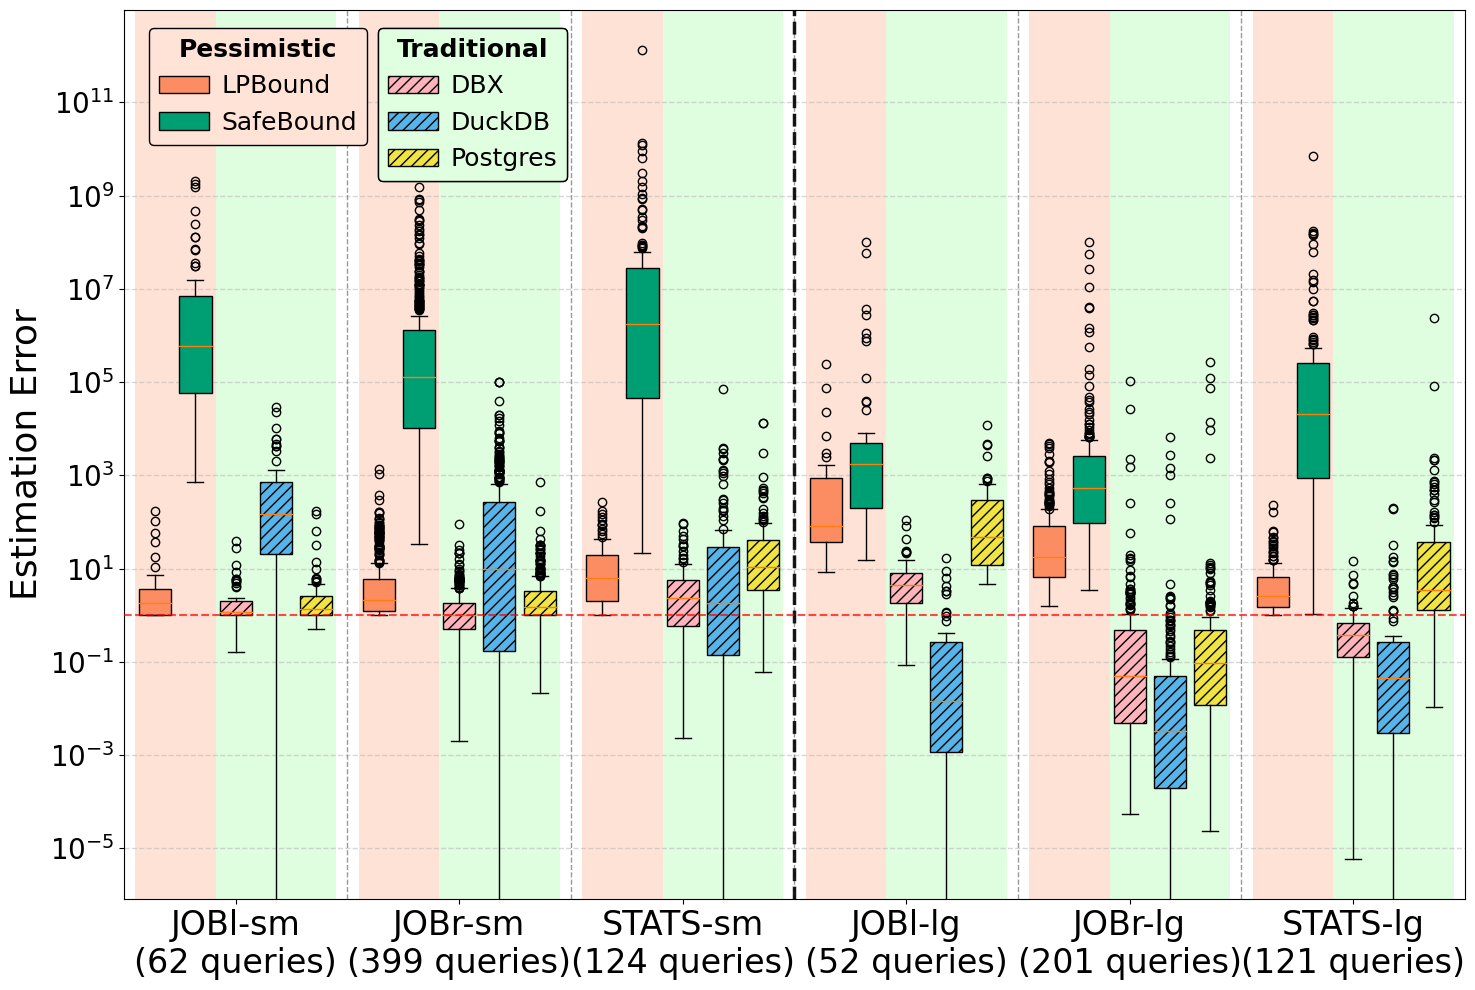

In [9]:
dfs = []
titles = []
methods = []
for query_set in ["small", "large"]: # small domain
    for benchmark in ["joblight", "jobrange", "stats"]:
        df, title, method = draw_groupby_estimates(benchmark, query_set)
        dfs.append(df)
        titles.append(title)
        methods.append(method)
draw_combined_trend_plot(dfs, titles, methods, "groupby_estimates_combined.pdf", label_total_width=0.32, label_start_x=0.1, draw_middle_line=True)

# Breakdown of the estimation error for group-by queries with different number of relations

In [10]:
benchmarks = ["joblight", "jobrange", "stats"]

## Small Domain Sizes

- LpBound and psql use the product of the domain sizes of the group-by variables as the cardinality estimation. They are accurate.
- DuckDB uses the CE of the full join thus overestimates the cardinality.


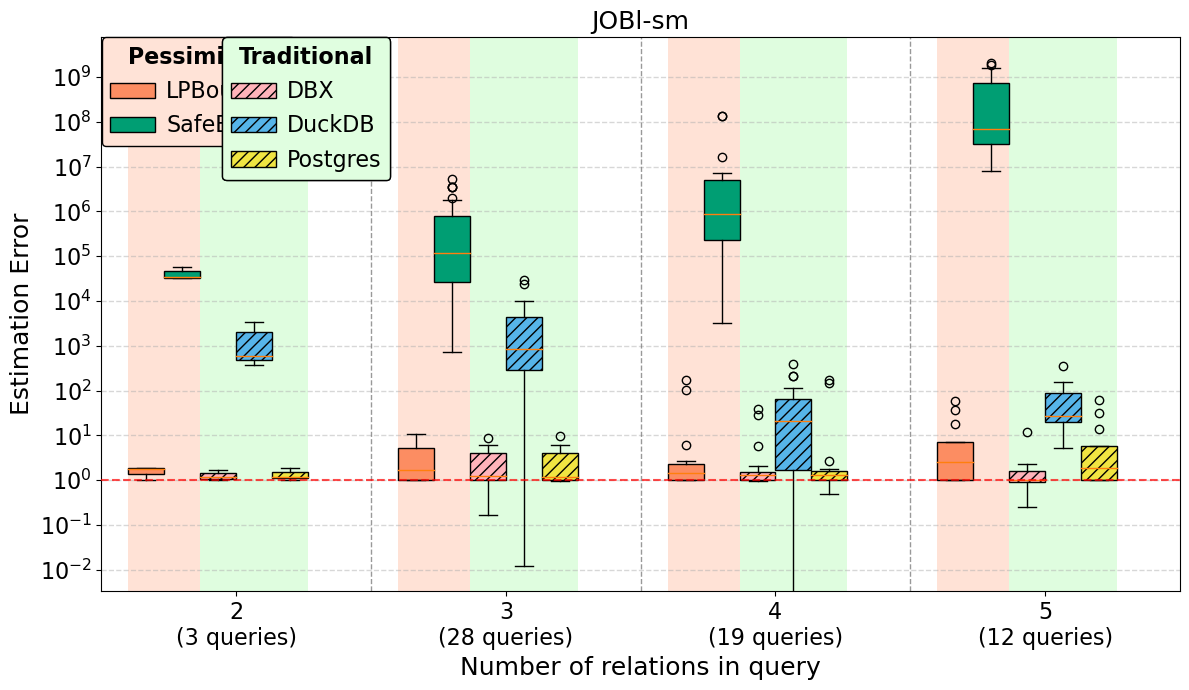

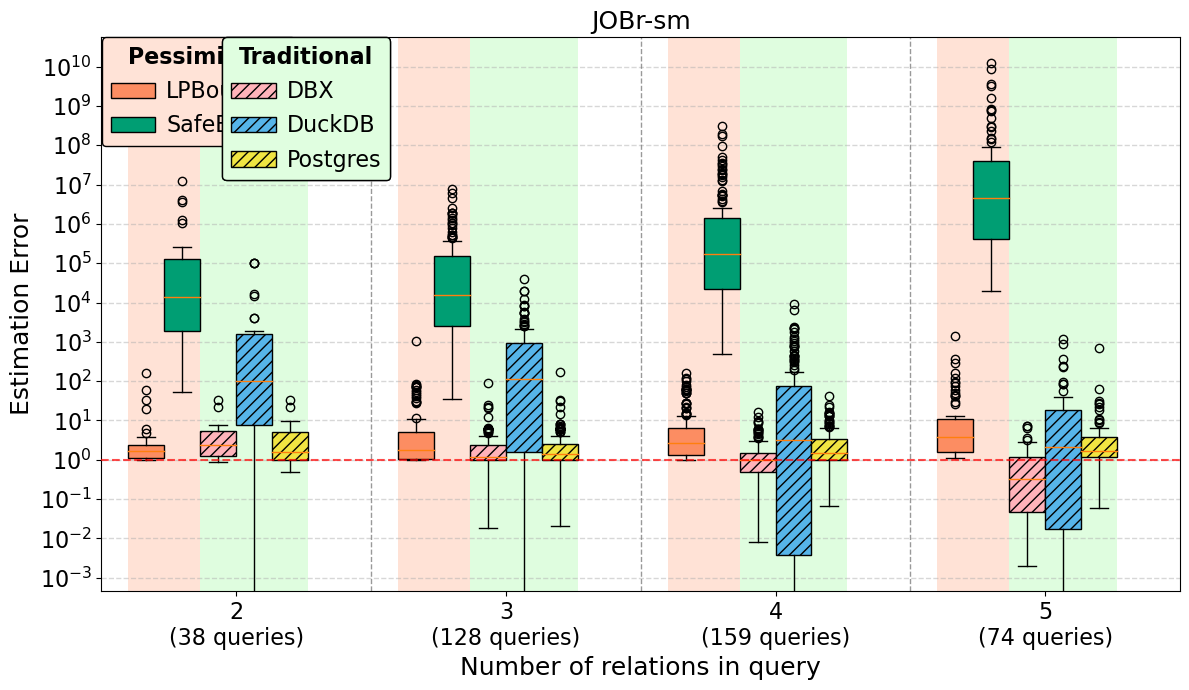

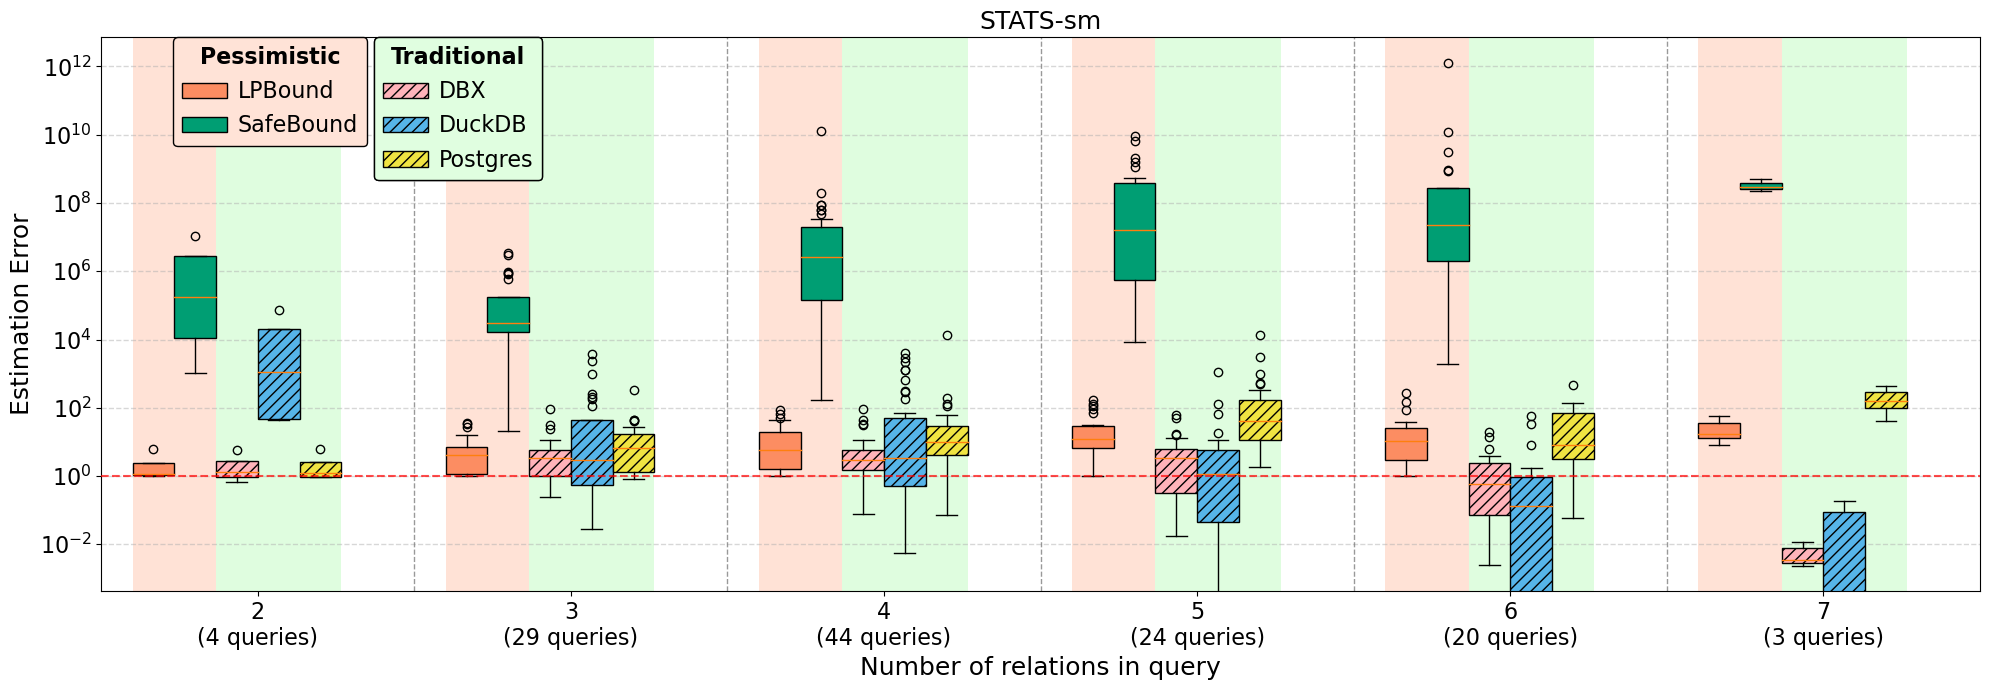

In [11]:
_df, _title, _methods = draw_groupby_estimates("joblight", "small")
draw_trend_plot(_df, _title, _methods, label_positions=[0, 0.1, 0.2, 0.31], draw_ratio=False, show_all_group=False, output_filename="estimates-joblight.pdf", figsize=(12, 7))

_df, _title, _methods = draw_groupby_estimates("jobrange", "small")
draw_trend_plot(_df, _title, _methods, label_positions=[0, 0.1, 0.2, 0.31], draw_ratio=False, show_all_group=False, output_filename="estimates-jobrange.pdf", figsize=(12, 7))

_df, _title, _methods = draw_groupby_estimates("stats", "small")
draw_trend_plot(_df, _title, _methods, label_positions=[0, 0.1, 0.2, 0.31], draw_ratio=False, show_all_group=False, output_filename="estimates-stats.pdf", figsize=(20, 7))

## Large Domain Sizes

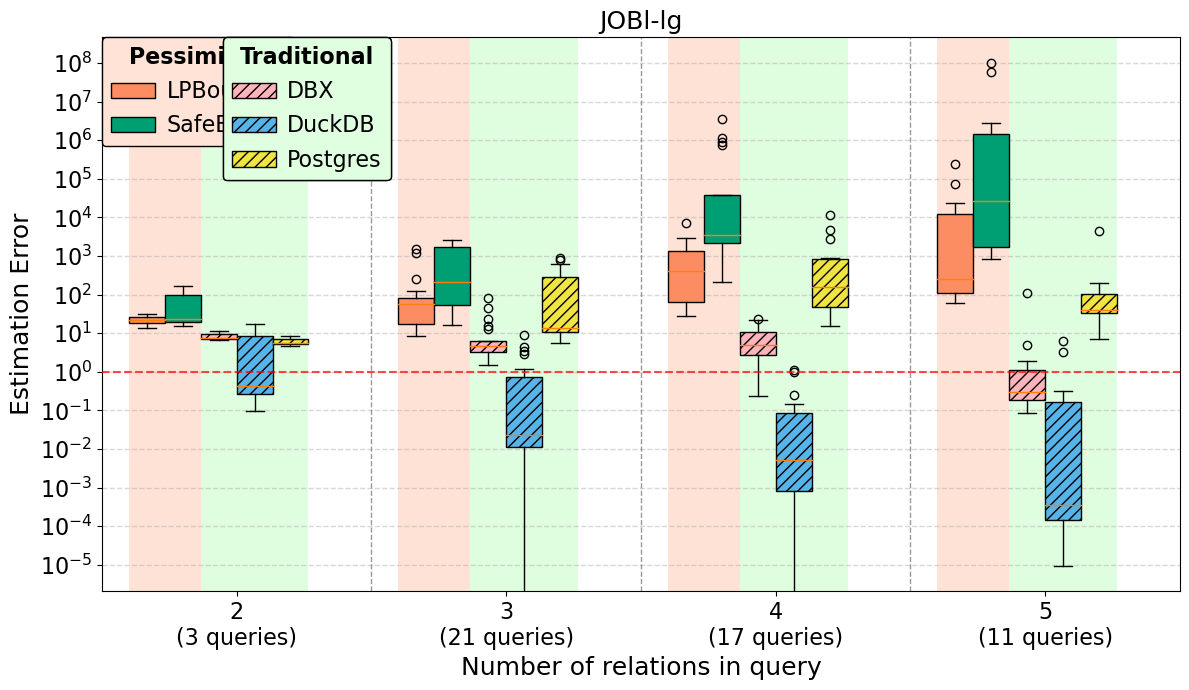

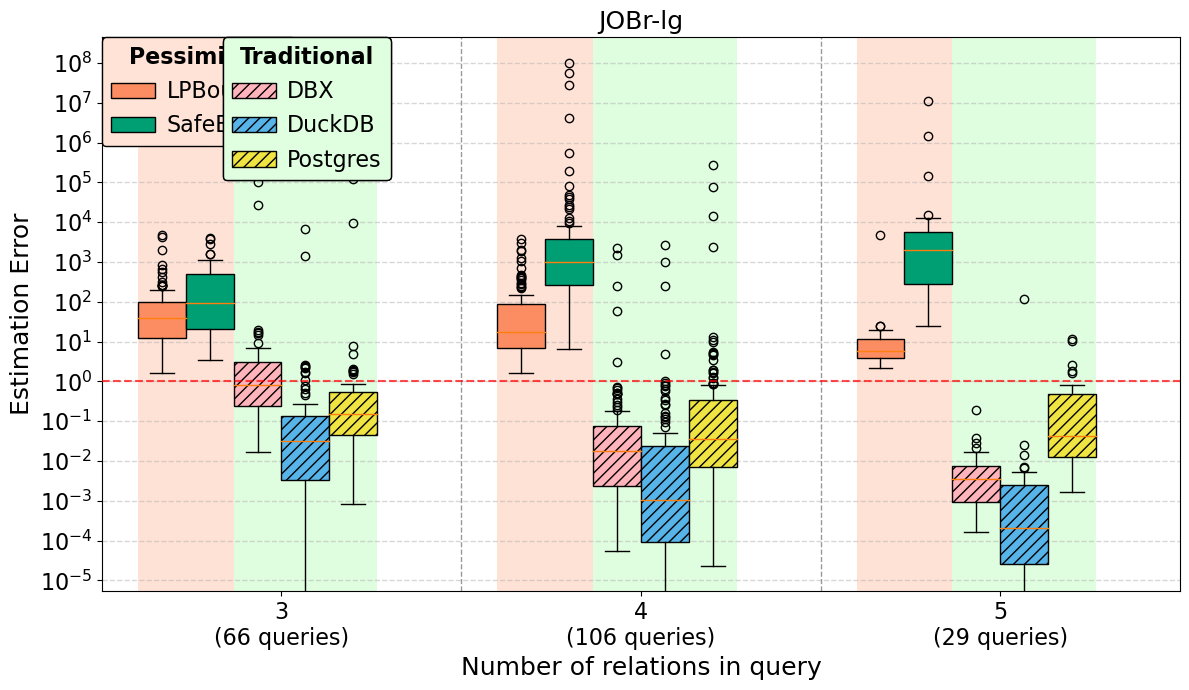

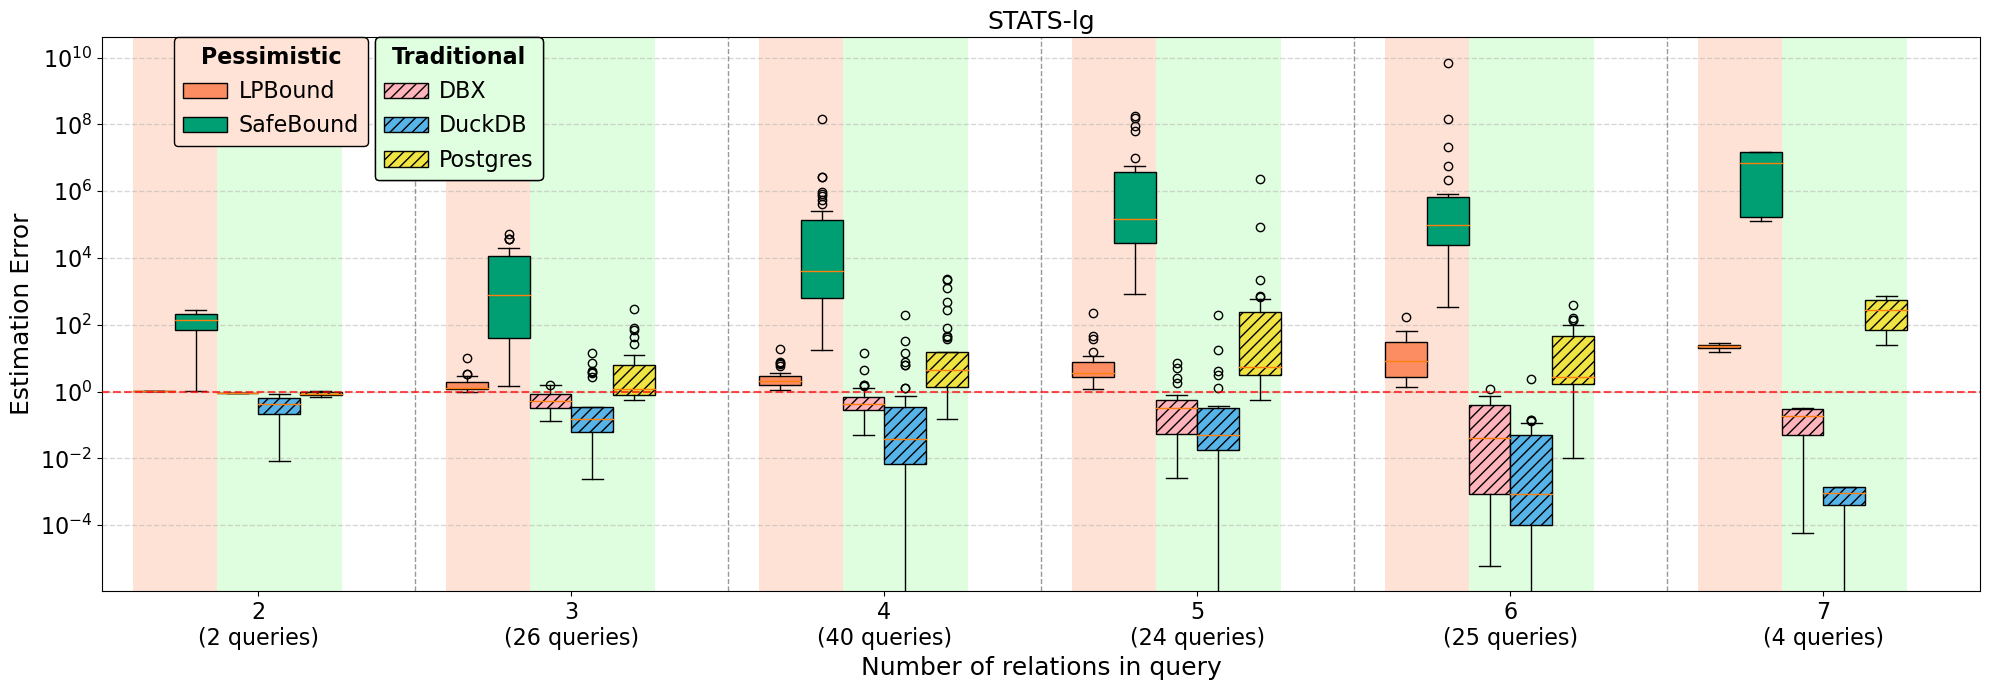

In [12]:
_df, _title, _methods = draw_groupby_estimates("joblight", "large")
draw_trend_plot(_df, _title, _methods, label_positions=[0, 0.1, 0.2, 0.31], draw_ratio=False, show_all_group=False, output_filename="estimates-joblight.pdf", figsize=(12, 7))

_df, _title, _methods = draw_groupby_estimates("jobrange", "large")
draw_trend_plot(_df, _title, _methods, label_positions=[0, 0.1, 0.2, 0.31], draw_ratio=False, show_all_group=False, output_filename="estimates-jobrange.pdf", figsize=(12, 7))

_df, _title, _methods = draw_groupby_estimates("stats", "large")
draw_trend_plot(_df, _title, _methods, label_positions=[0, 0.1, 0.2, 0.31], draw_ratio=False, show_all_group=False, output_filename="estimates-stats.pdf", figsize=(20, 7))

## Mixed Domain Sizes

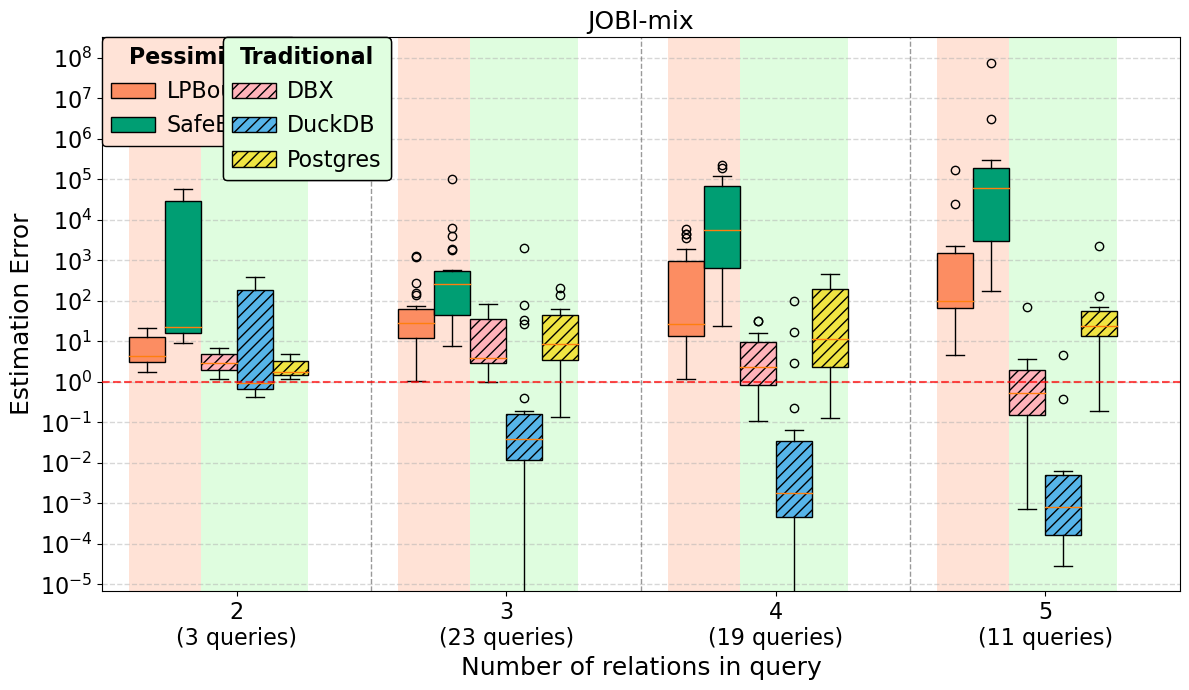

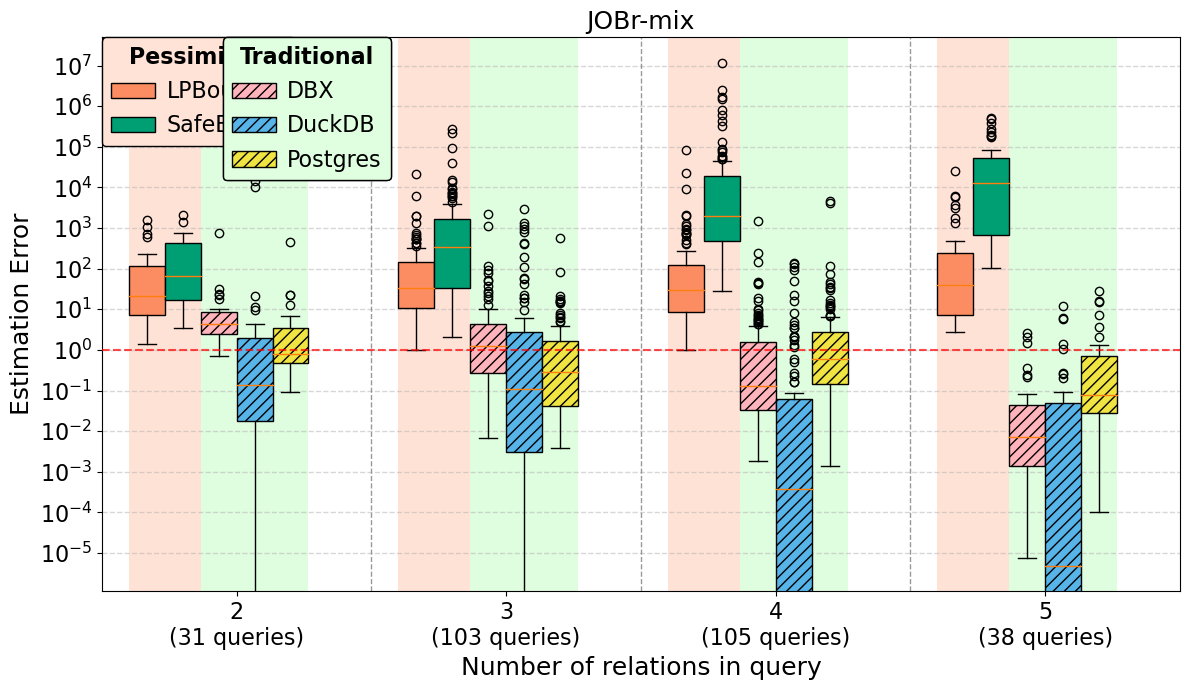

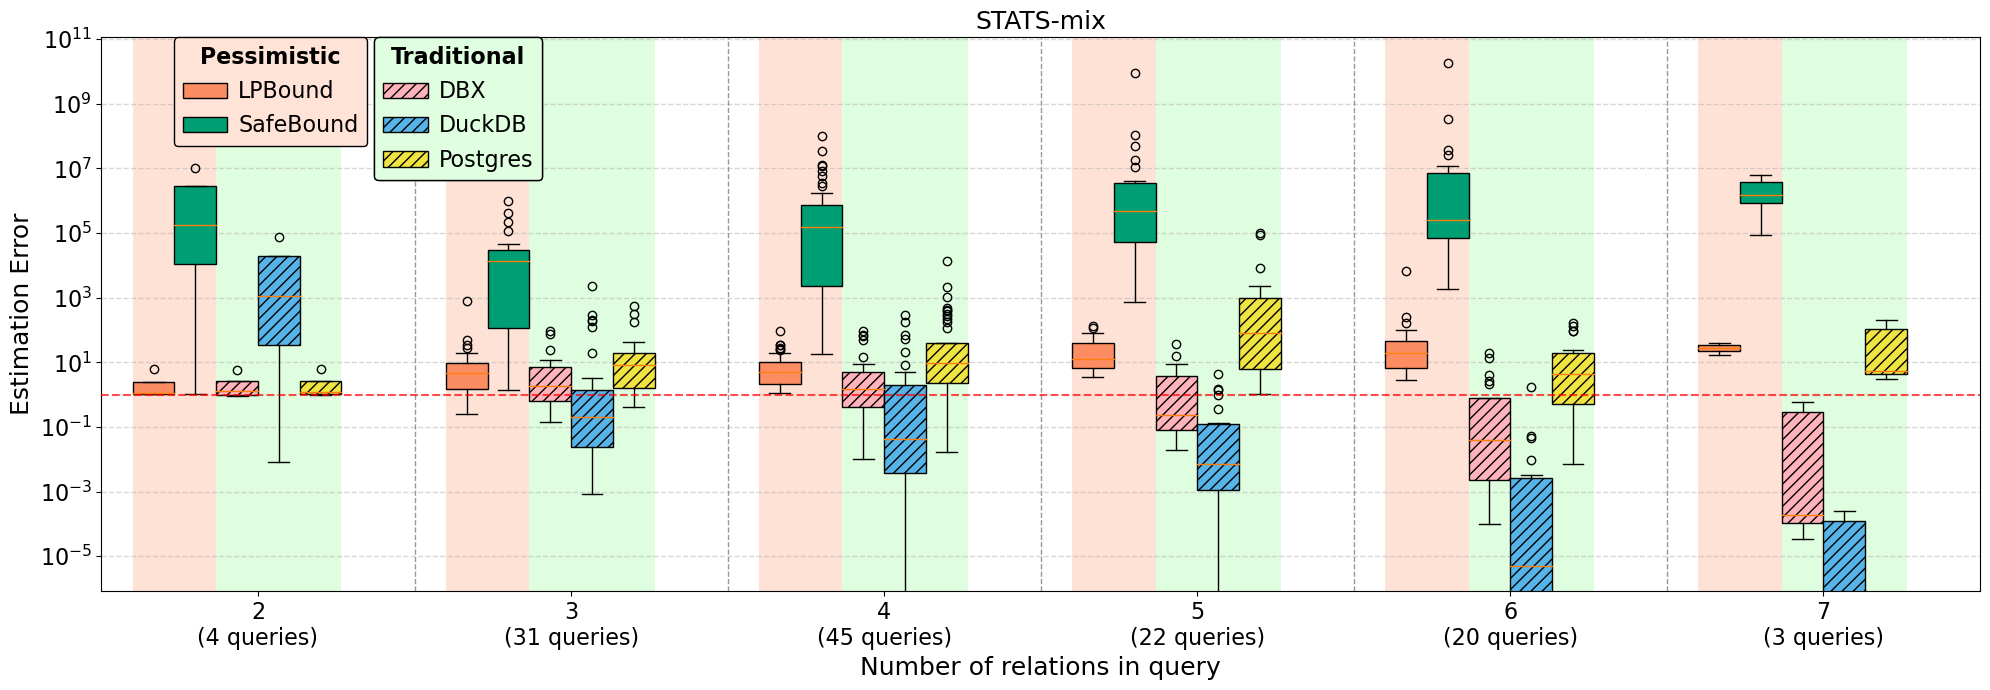

In [13]:
_df, _title, _methods = draw_groupby_estimates("joblight", "mixed")
draw_trend_plot(_df, _title, _methods, label_positions=[0, 0.1, 0.2, 0.31], draw_ratio=False, show_all_group=False, output_filename="estimates-joblight.pdf", figsize=(12, 7))

_df, _title, _methods = draw_groupby_estimates("jobrange", "mixed")
draw_trend_plot(_df, _title, _methods, label_positions=[0, 0.1, 0.2, 0.31], draw_ratio=False, show_all_group=False, output_filename="estimates-jobrange.pdf", figsize=(12, 7))

_df, _title, _methods = draw_groupby_estimates("stats", "mixed")
draw_trend_plot(_df, _title, _methods, label_positions=[0, 0.1, 0.2, 0.31], draw_ratio=False, show_all_group=False, output_filename="estimates-stats.pdf", figsize=(20, 7))